# Regularized FEVD estimation
## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append('../')
sys.path.append('../../kungfu/')

import src
import kungfu as kf

/home/rubelrennfix/.virtualenvs/euraculus/lib/python3.6/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


## Load data

In [3]:
df_estimation_stats = pd.read_csv('../data/estimated/estimation_statistics.csv')
df_estimation_stats = df_estimation_stats.rename(columns={'Unnamed: 0': 'year'})
df_estimation_stats['year'] = pd.to_datetime(df_estimation_stats['year'])
df_estimation_stats = df_estimation_stats.set_index('year')

## Calculations

In [4]:
df_estimation_stats['mean_shrinkage'] = (df_estimation_stats['var_nonzero_shrinkage']+df_estimation_stats['covar_full_shrinkage'])/2
df_estimation_stats['cov_used_df'] = (df_estimation_stats['precision_density']*df_estimation_stats['N']**2-df_estimation_stats['N'])/2 + df_estimation_stats['N']
df_estimation_stats['var_regular_lost_df'] = df_estimation_stats['N']**2+df_estimation_stats['N']
df_estimation_stats['covar_regular_lost_df'] = (df_estimation_stats['N']*(df_estimation_stats['N']-1))/2
df_estimation_stats['var_estimate_share'] = df_estimation_stats['var_regular_lost_df']/(df_estimation_stats['var_regular_lost_df']+df_estimation_stats['covar_regular_lost_df'])
df_estimation_stats['mean_density'] = (df_estimation_stats['var_matrix_density']*df_estimation_stats['var_estimate_share']\
                                       +(1-df_estimation_stats['var_estimate_share'])*df_estimation_stats['precision_density'])

In [5]:
df_estimation_stats.mean().round(2).to_frame()

,0
T,251.77
N,100.00
nobs,25176.92
lambda,1.62
kappa,0.00
var_matrix_density,0.58
var_mean_connection,0.00
var_mean_abs_connection,0.02
var_asymmetry,0.84
var_r2,0.24


## Plotting
open:
- Subplot 3, decide FEV vs FU
- decide normalised

In [6]:
def plot_estimation_summary(df, save_path=None):
    fig, axes = plt.subplots(4, 1, figsize=(20, 16))
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    
    # hyperparameters
    ax1 = axes[0]
    ax2 = ax1.twinx()
    ax1.set_title('Cross-validated hyperparameters')
    l1 = ax1.plot(df['lambda'], linestyle='-', label='λ, mean={}'.format(df['lambda'].mean().round(2)), c=colors[0])
    l2 = ax1.plot(df['kappa'], linestyle='--', label='κ, mean={:.1e}'.format(df['kappa'].mean()), c=colors[1])
    l3 = ax2.plot(df['rho'], linestyle='-.', label='ρ, mean={}'.format(df['rho'].mean().round(2)), c=colors[2])
#     l4 = ax2.plot(df['eta'], linestyle=':', label='η, mean={}'.format(df['eta'].mean().round(2)), c=colors[3])
    ax1.set_ylim([1e-5, 1e2])
    ax2.set_ylim([1e-2, 1e0])
    ax1.set_yscale('log')
    ax2.set_yscale('log')
    ax2.grid(None)
    ax1.set_ylabel('VAR hyperparameters', color=colors[0])
    ax1.tick_params(axis='y', labelcolor=colors[0])
    ax2.set_ylabel('Covariance hyperparamters', color=colors[2])
    ax2.tick_params(axis='y', labelcolor=colors[2])
    lines = l1+l2+l3#+l4
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels)
    kf.plotting.add_recession_bars(ax1, freq='M', startdate=df.index[0], enddate=df.index[-1])
    
    # Losses
    ax1 = axes[1]
    ax2 = ax1.twinx()
    ax1.set_title('Cross-validation losses')
    l11 = ax1.plot(df['var_cv_loss'], linestyle='-', label='VAR CV loss, mean={}'.format(df['var_cv_loss'].mean().round(2)), c=colors[0])
    l12 = ax1.plot(df['var_train_loss'], linestyle='--', label='VAR train loss, mean={}'.format(df['var_train_loss'].mean().round(2)), c=colors[0])
    l21 = ax2.plot(df['covar_cv_loss'], linestyle='-.', label='Covariance CV loss, mean={}'.format(df['covar_cv_loss'].mean().round(2)), c=colors[1])
    l22 = ax2.plot(df['covar_train_loss'], linestyle=':', label='Covariance train loss, mean={}'.format(df['covar_train_loss'].mean().round(2)), c=colors[1])
    ax1.set_ylim([0, 1])
    #ax2.set_ylim([0, 500])
    ax2.grid(None)
    ax1.set_ylabel('VAR MSE', color=colors[0])
    ax1.tick_params(axis='y', labelcolor=colors[0])
    ax2.set_ylabel('Covariance loss', color=colors[1])
    ax2.tick_params(axis='y', labelcolor=colors[1])
    lines = l11+l12+l21+l22
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels)
    kf.plotting.add_recession_bars(ax1, freq='M', startdate=df.index[0], enddate=df.index[-1])
    
    # R2
    ax = axes[2]
    ax.set_title('Goodness of fit')
    ax.plot(df_estimation_stats['var_r2'], label='VAR R², mean={}'.format(df['var_r2'].mean().round(2)))
    ax.set_ylim([0, 1])
    ax.legend()
    kf.plotting.add_recession_bars(ax, freq='M', startdate=df.index[0], enddate=df.index[-1])
    
    # Degrees of Freedom
    ax = axes[3]
    ax.set_title('Degrees of freedom')
    ax.fill_between(df.index, 0, df['var_df_used'], alpha=0.5, label='DFs used by VAR estimation, mean={}'.format(int(df['var_df_used'].mean())), color=colors[0])
    ax.plot(df['var_df_used'], c=colors[0], linewidth=1)
    ax.fill_between(df.index, df['var_df_used'], df['var_df_used']+df['cov_used_df'], alpha=0.5, label='DFs used by covariance estimation, mean={}'.format(int(df['cov_used_df'].mean())), color=colors[1])
    ax.plot(df['var_df_used']+df['cov_used_df'], c=colors[1], linewidth=1)
    ax.fill_between(df.index, df['var_df_used']+df['cov_used_df'], df['nobs'], alpha=0.3, label='Remaining DFs, mean={}'.format(int((df['nobs']-df['var_df_used']-df['cov_used_df']).mean())), color=colors[2])
    ax.plot(df['nobs'], c=colors[2], label='Total data points, mean={}'.format(int(df['nobs'].mean())))
    ax.plot(df['var_regular_lost_df'], c=colors[0], label='Non-regularised VAR DFs', linestyle='--', linewidth=1.5)
    ax.plot(df['var_regular_lost_df']+df['covar_regular_lost_df'], c=colors[1], label='Non-regularised total DFs', linestyle='-.', linewidth=1.5)
    ax.legend()
    kf.plotting.add_recession_bars(ax, freq='M', startdate=df.index[0], enddate=df.index[-1])
    
    if save_path:
        fig.savefig(save_path, format='pdf', dpi=200, bbox_inches='tight')

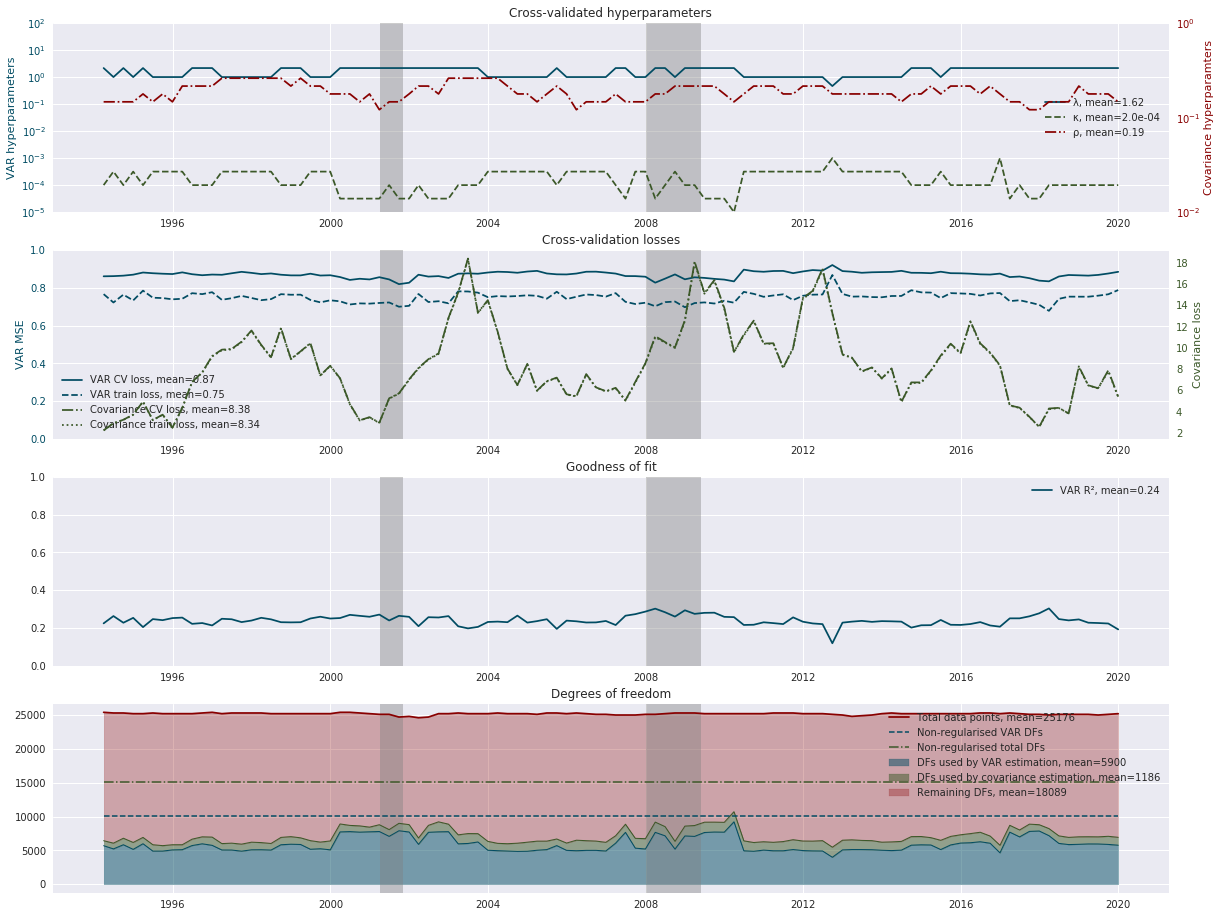

In [130]:
plot_estimation_summary(df_estimation_stats, save_path='../reports/figures/estimation_summary.pdf')

In [8]:
def plot_estimate_summary(df, save_path=None):
    fig, axes = plt.subplots(3, 1, figsize=(20, 12))
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    # Sparsity
    ax = axes[0]
    ax.set_title('Estimate sparsity')
    ax.plot(1-df['var_matrix_density'], linestyle='-', label='VAR matrix sparsity, mean={}'.format((1-df['var_matrix_density']).mean().round(2)))
    ax.plot(1-df['precision_density'], linestyle='--', label='Precision matrix sparsity, mean={}'.format((1-df['precision_density']).mean().round(2)))
    ax.plot(1-df['mean_density'], linestyle='-.', label='Overall estimate sparsity, mean={}'.format((1-df['mean_density']).mean().round(2)))
    ax.set_ylim([0, 1])
    ax.legend()
    kf.plotting.add_recession_bars(ax, freq='M', startdate=df.index[0], enddate=df.index[-1])
    
    # Shrinkage
    ax = axes[1]
    ax.set_title('Estimate shrinkage')
    ax.plot(df['var_nonzero_shrinkage'], linestyle='-', label='VAR matrix shrinkage, mean={}'.format((df['var_nonzero_shrinkage']).mean().round(2)))
    ax.plot(df['covar_nonzero_shrinkage'], linestyle='--', label='Covariance matrix shrinkage, mean={}'.format((df['covar_nonzero_shrinkage']).mean().round(2)))
    ax.plot(df['mean_shrinkage'], linestyle='-.', label='Overall estimate shrinkage, mean={}'.format((df['mean_shrinkage']).mean().round(2)))
    ax.set_ylim([0, 1])
    ax.legend()
    kf.plotting.add_recession_bars(ax, freq='M', startdate=df.index[0], enddate=df.index[-1])
    
    # Network stats
    ax1 = axes[2]
    ax2 = ax1.twinx()
    ax1.set_title('FEV Network statistics')
    l1 = ax1.plot(df['fev_avg_connectedness_normalised'], label='Average connectedness $c^{avg}$, mean='+str((df['fev_avg_connectedness_normalised']).mean().round(2)), c=colors[0])
    l2 = ax2.plot(df['fev_asymmetry_normalised'], label='Network asymmetry, mean={}'.format((df['fev_asymmetry_normalised']).mean().round(2)), linestyle='--', c=colors[1])
    ax2.grid(None)
    ax1.set_ylabel('Connectedness', color=colors[0])
    ax1.tick_params(axis='y', labelcolor=colors[0])
    ax2.set_ylabel('Asymmetry', color=colors[1])
    ax2.tick_params(axis='y', labelcolor=colors[1])
    lines = l1+l2
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels)
    kf.plotting.add_recession_bars(ax1, freq='M', startdate=df.index[0], enddate=df.index[-1])
    
    if save_path:
        fig.savefig(save_path, format='pdf', dpi=200, bbox_inches='tight')

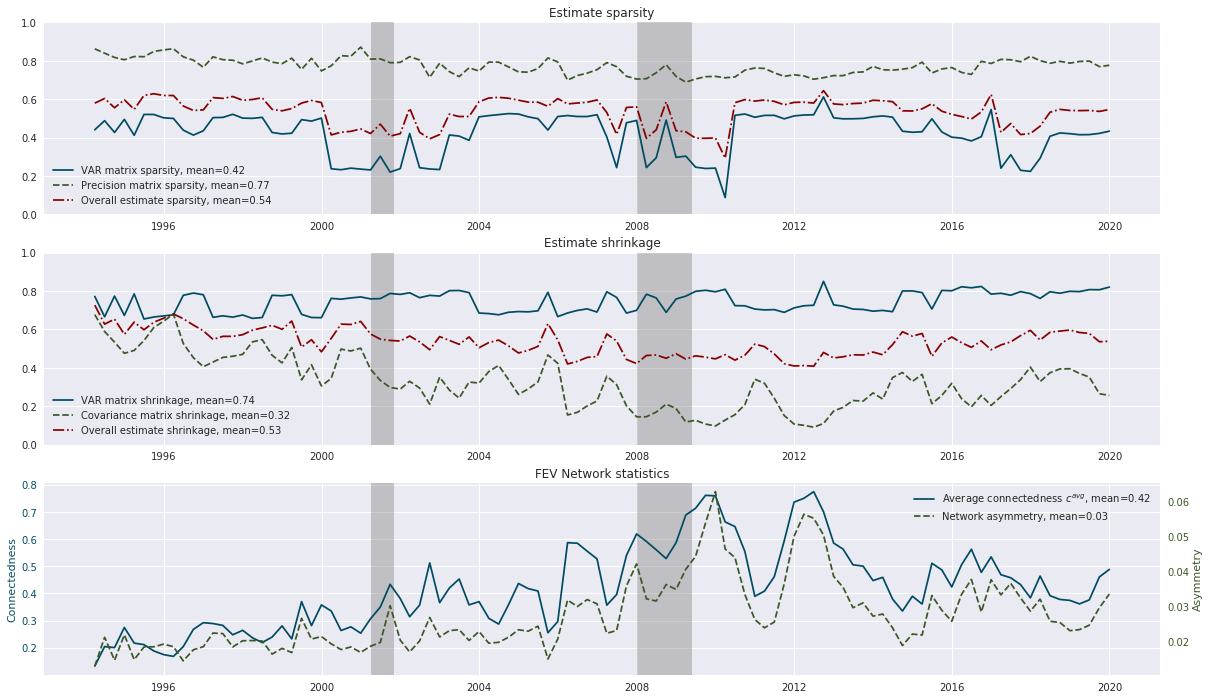

In [132]:
plot_estimate_summary(df_estimation_stats, save_path='../reports/figures/estimate_summary.pdf')

In [133]:
from sklearn.covariance import GraphicalLasso

In [134]:
g = GraphicalLasso()

In [137]:
df_estimation_stats

,T,N,nobs,lambda,kappa,var_matrix_density,var_mean_connection,var_mean_abs_connection,var_asymmetry,var_r2,...,fev_asymmetry,fev_asymmetry_normalised,fu_asymmetry,fu_asymmetry_normalised,mean_shrinkage,cov_used_df,var_regular_lost_df,covar_regular_lost_df,var_estimate_share,mean_density
year,,,,,,,,,,,,,,,,,,,,,
1994-03-31,254.0,100.0,25400.0,2.154435,0.000100,0.5592,0.003340,0.012001,0.765068,0.225044,...,0.012822,0.012982,0.114016,0.120614,0.726392,737.0,10100.0,4950.0,0.671096,0.420468
1994-06-30,253.0,100.0,25300.0,1.000000,0.000316,0.5118,0.004314,0.017133,0.830886,0.263589,...,0.020675,0.021182,0.144306,0.154740,0.627653,850.0,10100.0,4950.0,0.671096,0.396092
1994-09-30,253.0,100.0,25300.0,2.154435,0.000100,0.5732,0.004500,0.012226,0.774424,0.228389,...,0.013635,0.014659,0.102976,0.128644,0.653879,961.0,10100.0,4950.0,0.671096,0.444599
1994-12-30,252.0,100.0,25200.0,1.000000,0.000316,0.5051,0.003931,0.016694,0.812635,0.254135,...,0.020096,0.021901,0.122202,0.152094,0.574379,1021.0,10100.0,4950.0,0.671096,0.402844
1995-03-31,252.0,100.0,25200.0,2.154435,0.000100,0.5880,0.002828,0.012142,0.803309,0.205168,...,0.012360,0.014809,0.094838,0.131398,0.637896,937.0,10100.0,4950.0,0.671096,0.452952
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31,251.0,100.0,25100.0,2.154435,0.000100,0.5796,0.001670,0.013082,0.844807,0.245903,...,0.017867,0.023068,0.090678,0.136987,0.597039,1109.0,10100.0,4950.0,0.671096,0.458629
2019-03-29,251.0,100.0,25100.0,2.154435,0.000100,0.5850,0.002317,0.012858,0.837320,0.228485,...,0.017568,0.023379,0.096134,0.138319,0.583989,1066.0,10100.0,4950.0,0.671096,0.459425
2019-06-28,250.0,100.0,25000.0,2.154435,0.000100,0.5844,0.002764,0.012549,0.830931,0.226844,...,0.018131,0.024639,0.091896,0.143068,0.579720,1055.0,10100.0,4950.0,0.671096,0.458298


In [138]:
g.fit(df_estimation_stats.iloc[:, 4:8])

GraphicalLasso()

In [ ]:
g.

In [149]:
sp.stats.multivariate_normal(cov=g.covariance_).logpdf(df_estimation_stats.iloc[:, 4:8].values).sum()

-2363.5443628327166